In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from utils import db_connect

pd.set_option('display.max_columns', None)

engine = db_connect()

# bring in the data
main_df = pd.read_sql('SELECT * FROM combined_data', con=engine)

# function to mark whether a school was operational all five years of data
# creates our 'Currently operational' feature
def mark_always_operational(main_df):
    
    total_years = main_df['SURVYEAR'].nunique()
    
    main_df['SY_STATUS_TEXT'] = main_df['SY_STATUS_TEXT'].str.strip()
    
    operational_counts = (
        main_df[main_df['SY_STATUS_TEXT'] == 'Currently operational']
        .groupby('NCESSCH')['SURVYEAR']
        .nunique()
    )
    
    always_operational_schools = operational_counts[operational_counts == total_years].index
    
    main_df['concurrently_operational'] = main_df['NCESSCH'].isin(always_operational_schools)
    
    return main_df

# apply the function
mark_always_operational(main_df=main_df)

# drop records that were not fully operational across all five years
main_df = main_df[main_df['concurrently_operational'] != False]

# strip whitespace
for col in main_df.select_dtypes(include=["string"]).columns:
    main_df[col] = main_df[col].str.strip()

# begin defining data type conversion processes
# Change columns to floats
float_cols = ["X", "Y", "LATCOD", "LONCOD", "FTE", "STUTERATIO"]

# change columns to int
int_cols = [
    "OBJECTID", "GSLO", "GSHI",
    "TOTFRL", "FRELCH", "REDLCH", "DIRECTCERT",
    "PK", "KG", "G01", "G02", "G03", "G04", "G05", "G06",
    "G07", "G08", "G09", "G10", "G11", "G12", "G13",
    "UG", "AE",
    "TOTMENROL", "TOTFENROL", "TOTAL", "MEMBER",
    "AMALM", "AMALF", "AM",
    "ASALM", "ASALF", "AS",
    "BLALM", "BLALF", "BL",
    "HPALM", "HPALF", "HP",
    "HIALM", "HIALF", "HI",
    "TRALM", "TRALF", "TR",
    "WHALM", "WHALF", "WH"
]

# Change columns to strings
string_cols = [
    "NCESSCH", "SURVYEAR", "STABR", "LEAID", "ST_LEAID",
    "LEA_NAME", "SCH_NAME",
    "LSTREET1", "LSTREET2", "LCITY", "LSTATE",
    "LZIP", "LZIP4", "PHONE",
    "VIRTUAL", "SCHOOL_LEVEL", "SCHOOL_TYPE_TEXT",
    "STATUS", "SY_STATUS_TEXT", "ULOCALE", "NMCNTY",
    "CHARTER_TEXT", "LSTREET3", "TITLEI", "STITLEI", "MAGNET_TEXT"
]

# function to clean NCES error codes
def clean_nces_error_codes(main_df, cols):
    error_values = [
    "M", "N", "-1", "-2", "-9",
    "Missing", "Not applicable", "Not Applicable",
    -1, -2, -9
]
    main_df[cols] = main_df[cols].replace(error_values, np.nan)
    return main_df

# clean ALL columns 
cols = float_cols + int_cols + string_cols
main_df = clean_nces_error_codes(main_df, cols)

# convert floats safely
for col in float_cols:
    main_df[col] = pd.to_numeric(main_df[col], errors="coerce")

    # convert ints safely
for col in int_cols:
    main_df[col] = pd.to_numeric(main_df[col], errors="coerce").astype("Int64")

    # convert strings
for col in string_cols:
    main_df[col] = main_df[col].astype("string")

    # round coordinates
main_df["LATCOD"] = main_df["LATCOD"].round(4)
main_df["LONCOD"] = main_df["LONCOD"].round(4)

# extract start Year - convert to int for sorting
main_df['SURVYEAR'] = main_df['SURVYEAR'].str[:4].astype(int)

# removing virtual schools
main_df = main_df[main_df['VIRTUAL'].isin(['Not Virtual', 'Not a virtual school'])]

# drop the virtual feature
main_df.drop(columns='VIRTUAL', inplace=True)

# only keeping 'regular' public schools, removing: [ 'Career and Technical School',
# 'Special education school', 'Alternative Education School',
# 'Alternative/other school', 'Vocational school']
main_df = main_df[main_df['SCHOOL_TYPE_TEXT'].isin(['Regular school', 'Regular School'])]

# drop the SCHOOL_TYPE_TEXT feature
main_df.drop(columns='SCHOOL_TYPE_TEXT', inplace=True)

# define additional redundant columns
redundant_cols = ['X', 'Y', 'OBJECTID', 'ST_LEAID', 'LSTREET1', 'LSTREET2', 'LSTREET3', 
                  'LZIP4', 'PHONE', 'AMALM', 'AMALF', 'ASALM', 'ASALF', 
                  'BLALM', 'BLALF', 'HPALM', 'HPALF', 'HIALM', 'HIALF', 'TRALM', 'TRALF', 
                  'WHALM', 'WHALF', 'STABR', 'LCITY', 'LSTATE', 'LZIP', 'SCHOOL_LEVEL', 'GSLO', 'GSHI'
                  , 'STATUS', 'SY_STATUS_TEXT', 'NMCNTY', 'DIRECTCERT', 'AE', 'TOTFENROL', 'TOTMENROL']

# drop additional redundant cols
main_df = main_df.drop(columns=redundant_cols)

# replace na values with 0
main_df = main_df.fillna(0)

# Checking records against all five years
counts = main_df["NCESSCH"].value_counts()
keep_ids = counts[counts == 5].index
filtered_df = main_df[main_df["NCESSCH"].isin(keep_ids)].copy()

print(f"main_df shape: {main_df.shape}")
print(f"filtered_df shape: {filtered_df.shape}")

# Simplify ULOCALE
filtered_df["locale_category"] = filtered_df["ULOCALE"].str.split("-").str[1].str.split(":").str[0]

# Drop the ULOCALE feature because we now have our simplified locale_category feature
filtered_df.drop(columns='ULOCALE', inplace=True)


Connection successful
main_df shape: (317361, 43)
filtered_df shape: (202600, 43)


In [275]:
# after filtering, work out of filtered df
filtered_df.shape

(202600, 43)

In [283]:
filtered_df['TITLEI'].unique()

array(['2-No', '1-Yes', 0,
       '3-Title I schoolwide eligible-Title I targeted assistance program',
       '6-Not a Title I school', '2-Title I targeted assistance school',
       '5-Title I schoolwide school',
       '1-Title I targeted assistance eligible school-No program',
       '4-Title I schoolwide eligible school-No program'], dtype=object)

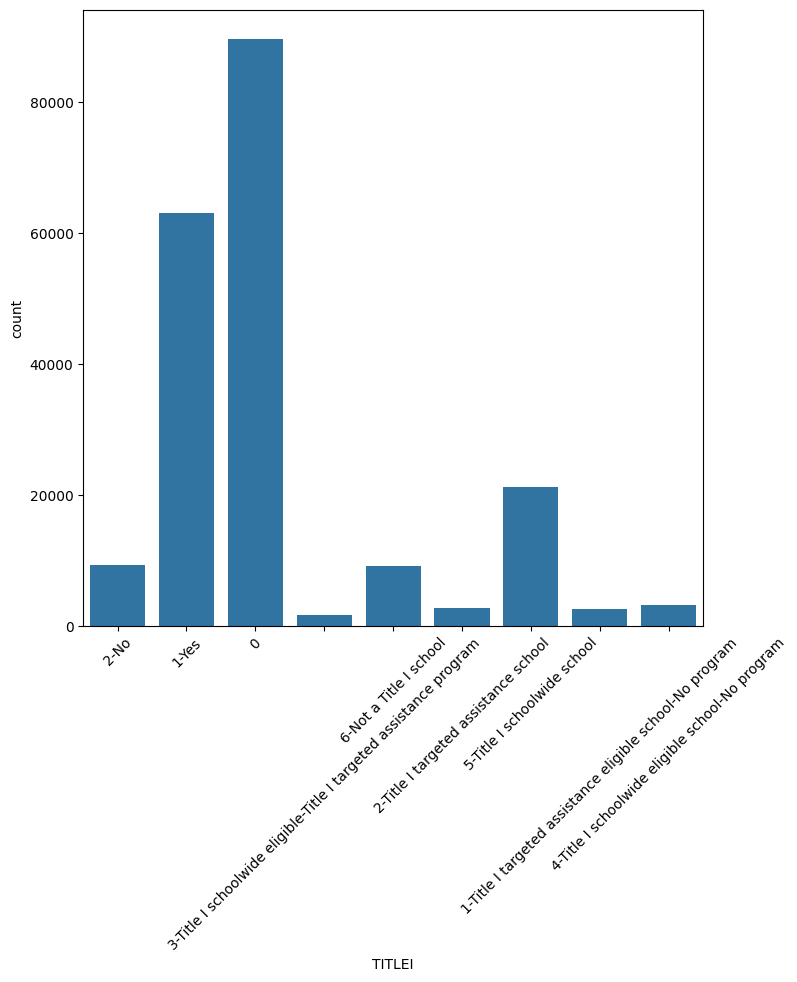

In [278]:
plt.figure(figsize=(8,8))
sns.countplot(data=filtered_df, x='TITLEI')
plt.xticks(rotation=45)
plt.show()

In [284]:
filtered_df['ULOCALE'].unique()

<StringArray>
[     '11-City: Large', '22-Suburb: Mid-size',    '41-Rural: Fringe',
    '21-Suburb: Large',      '13-City: Small',    '32-Town: Distant',
    '43-Rural: Remote',     '33-Town: Remote',     '31-Town: Fringe',
   '42-Rural: Distant',   '12-City: Mid-size',    '23-Suburb: Small']
Length: 12, dtype: string

In [288]:
# Title I status breakdown
filtered_df['TITLEI'].unique()

array(['2-No', '1-Yes', 0,
       '3-Title I schoolwide eligible-Title I targeted assistance program',
       '6-Not a Title I school', '2-Title I targeted assistance school',
       '5-Title I schoolwide school',
       '1-Title I targeted assistance eligible school-No program',
       '4-Title I schoolwide eligible school-No program'], dtype=object)

In [289]:
filtered_df[filtered_df['TITLEI'] == 0].shape

(89631, 43)

In [ ]:
# Title I rough breakdown:

# Participating:
# 1 - Yes - School participates in Title I funding / programs
# 5 - Title I schoolwide school - ENTIRE school recieves Title I support. Funds can be used for all students
# 2 - Title I targeted assistance school - Only SPECIFIC eligible students recieve services (usually low-income or academically at risk)

# Eligible, but no program running:
# 4 - Title I schoolwide eligible school - no program - Enough low-income students to qualify for schoolwide funding, but not using it
# 1 - Title I targeted assistance eligible school - No program - Eligible for targeted assistance but not participating

# Hybrid
# 3 Title I schoolwide eligible - Title I targeted assitance program - School qualifies for schoolwide funding but has chosen to run only a targeted program

# Explicit non-participation
# 2 - No - School does not participate
# 6 - Not a Title I school

# 0
# 0 - Assuming missing, unknown, or not reported


# Conceptual differences:
# Schoolwide = whole school qualifies = High funding flexibility - Typical poverty threshold >= 40% low-income
# Targeted = only some students qualify = Limited funding flexibility - lower threshold for poverty


In [290]:
schoolwide = ['1-Yes', '5-Title I schoolwide school']
targeted = ['2-Title I targeted assistance school', '3-Title I schoolwide eligible-Title I targeted assistance program']
elig_no_participate = ['4-Title I schoolwide eligible school-No program', 
                       '1-Title I targeted assistance eligible school-No program']
not_elig = ['2-No', '6-Not a Title I school']
missing = [0]

def group_titlei(col_TITLEI):
    if col_TITLEI in missing:
        return "Unknown"
    elif col_TITLEI in schoolwide:
        return "Schoolwide"
    elif col_TITLEI in targeted:
        return "Targeted"
    elif col_TITLEI in elig_no_participate:
        return "Eligible_No_Program"
    elif col_TITLEI in not_elig:
        return "Not_Eligible"
    else:
        return "Error"

In [291]:
filtered_df['TITLEI_GROUPED'] = filtered_df['TITLEI'].apply(group_titlei)

In [292]:
filtered_df[(filtered_df['TITLEI'] == '2-No') &
    (filtered_df['STITLEI'] != '2-No') &
    (filtered_df['STUTERATIO'] <= 1.0)].head(10) 

,NCESSCH,SURVYEAR,LEAID,LEA_NAME,SCH_NAME,CHARTER_TEXT,MAGNET_TEXT,TITLEI,STITLEI,TOTFRL,FRELCH,REDLCH,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,TOTAL,MEMBER,FTE,STUTERATIO,AM,AS,BL,HP,HI,TR,WH,LATCOD,LONCOD,concurrently_operational,locale_category,TITLEI_GROUPED
0,40088403264,2020,400884,ASU Preparatory Academy (92327),ASU Preparatory Academy-Polytechnic Middle School,Yes,0,2-No,0,0,0,0,0,0,0,0,0,0,110,119,118,0,0,0,0,0,0,0,347,347,0.0,0.0,3,13,22,2,155,26,126,33.3087,-111.6820,True,City,Not_Eligible
1,40088503410,2020,400885,Incito Schools (91326),Incito Schools,Yes,0,2-No,0,0,0,0,0,34,35,37,40,40,31,24,25,35,0,0,0,0,0,0,301,301,0.0,0.0,5,1,30,0,125,12,128,33.4553,-112.4088,True,Suburb,Not_Eligible
16,40089203012,2020,400892,Legacy Traditional School - Casa Grande (92199),Legacy Traditional School - Casa Grande,Yes,0,2-No,0,0,0,0,0,165,167,160,133,147,155,135,142,117,0,0,0,0,0,0,1321,1321,0.0,0.0,13,18,36,2,737,81,434,32.9012,-111.7324,True,City,Not_Eligible
20,40089703376,2020,400897,BASIS Charter Schools Inc. (91339),BASIS Ahwatukee,Yes,0,2-No,0,0,0,0,0,0,0,0,0,92,126,149,121,109,47,48,40,48,0,0,780,780,0.0,0.0,4,439,54,4,53,38,188,33.3542,-111.9754,True,City,Not_Eligible
21,40089803393,2020,400898,BASIS Charter Schools Inc. (91949),BASIS Mesa,Yes,0,2-No,0,0,0,0,0,60,84,61,60,75,90,71,73,66,58,42,41,32,0,0,813,813,0.0,0.0,2,192,56,1,132,55,375,33.3248,-111.6160,True,Rural,Not_Eligible
22,40089903392,2020,400899,Legacy Traditional School - Gilbert (92047),Legacy Traditional School ? Gilbert,Yes,0,2-No,0,0,0,0,0,147,147,128,140,141,127,118,124,65,0,0,0,0,0,0,1137,1137,0.0,0.0,7,73,62,2,250,120,623,33.3004,-111.7025,True,Suburb,Not_Eligible
24,40090203413,2020,400902,The Farm at Mission Montessori Academy (91340),The Farm at Mission Montessori Academy,Yes,0,2-No,0,0,0,0,0,0,0,0,0,0,0,23,10,16,0,0,0,0,0,0,49,49,0.0,0.0,1,2,1,0,7,0,38,33.5800,-111.9838,True,City,Not_Eligible
25,40090303418,2020,400903,BASIS Charter Schools Inc. (92320),BASIS Prescott,Yes,0,2-No,0,0,0,0,0,61,66,63,61,64,53,71,65,54,48,33,33,34,0,0,706,706,0.0,0.0,3,48,9,1,122,33,490,34.5901,-112.4313,True,Rural,Not_Eligible
27,40090503419,2020,400905,BASIS Charter Schools Inc. (92318),BASIS Oro Valley Primary,Yes,0,2-No,0,0,0,0,0,112,123,121,115,117,125,0,0,0,0,0,0,0,0,0,713,713,0.0,0.0,1,162,26,2,184,54,284,32.4089,-110.9456,True,Suburb,Not_Eligible
33,40091103440,2020,400911,Heritage Academy Queen Creek Inc. (92519),Heritage Academy Queen Creek,Yes,0,2-No,0,0,0,0,0,0,0,0,0,0,0,52,108,121,110,134,78,75,0,0,678,678,0.0,0.0,1,6,3,3,54,18,593,33.2774,-111.6585,True,Rural,Not_Eligible


In [293]:
filtered_df[filtered_df['STITLEI'] != 0]

,NCESSCH,SURVYEAR,LEAID,LEA_NAME,SCH_NAME,CHARTER_TEXT,MAGNET_TEXT,TITLEI,STITLEI,TOTFRL,FRELCH,REDLCH,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,TOTAL,MEMBER,FTE,STUTERATIO,AM,AS,BL,HP,HI,TR,WH,LATCOD,LONCOD,concurrently_operational,locale_category,TITLEI_GROUPED
2,40088603407,2020,400886,Archway Classical Academy Cicero (92314),Great Hearts Academies - Archway Cicero,Yes,0,1-Yes,2-No,0,0,0,0,85,89,84,93,87,94,0,0,0,0,0,0,0,0,0,532,532,0.000000,0.00,7,29,6,2,82,36,370,33.5415,-111.8897,True,Rural,Schoolwide
3,40088703415,2020,400887,Vista College Preparatory Inc. (91948),Vista College Preparatory,Yes,0,1-Yes,1-Yes,0,0,0,0,62,69,71,76,63,46,0,0,0,0,0,0,0,0,0,387,387,0.000000,0.00,2,1,67,0,299,5,13,33.4395,-112.0818,True,City,Schoolwide
8,40088803412,2020,400888,Archway Classical Academy Arete (92312),Great Hearts Academies - Archway Arete,Yes,0,1-Yes,2-No,0,0,0,0,94,88,91,90,90,89,0,0,0,0,0,0,0,0,0,542,542,0.000000,0.00,1,29,15,6,136,43,312,33.3784,-111.7369,True,Suburb,Schoolwide
9,40089003367,2020,400890,ASU Preparatory Academy (92325),ASU Preparatory Academy - Phoenix Middle School,Yes,0,1-Yes,1-Yes,0,0,0,0,0,0,0,0,0,102,110,109,119,0,0,0,0,0,0,440,440,0.000000,0.00,3,4,43,0,358,8,24,33.4537,-112.0644,True,City,Schoolwide
10,40089103399,2020,400891,Academy of Mathematics and Science South Inc. ...,Academy of Mathematics and Science South,Yes,0,1-Yes,1-Yes,0,0,0,0,85,58,61,83,68,62,59,57,60,0,0,0,0,0,0,593,593,0.000000,0.00,10,4,41,2,506,7,23,33.4852,-112.1306,True,City,Schoolwide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504831,130480002439,2017,1304800,Taylor County,Taylor County Middle School,No,No,0,Yes,133,122,11,0,0,0,0,0,0,0,0,94,98,0,0,0,0,0,0,192,192,16.000000,12.00,0,1,68,0,2,2,119,32.5541,-84.2325,True,Rural,Unknown
504832,130480002440,2017,1304800,Taylor County,Taylor County High School,No,No,0,Yes,266,244,22,0,0,0,0,0,0,0,0,0,0,111,114,96,90,0,0,411,411,27.299999,15.05,0,4,156,0,8,1,242,32.5540,-84.2324,True,Rural,Unknown
504833,130483002441,2017,1304830,Telfair County,Telfair County Middle School,No,No,0,Yes,376,376,0,0,0,0,0,0,0,0,136,124,130,0,0,0,0,0,0,390,390,28.000000,13.93,1,1,146,0,26,10,206,32.0476,-82.9113,True,Rural,Unknown
504834,130483002442,2017,1304830,Telfair County,Telfair County High School,No,No,0,Yes,470,470,0,0,0,0,0,0,0,0,0,0,0,132,132,105,118,0,0,487,487,30.600000,15.92,0,1,205,0,15,14,252,32.0468,-82.9109,True,Rural,Unknown


In [294]:
# "STITLEI" is used to indicate whether the school is eligible for school wide funding assistance through title i.. need to find a way 
# to utlizize this feature information alongside the "TITLEI" feature as well.
filtered_df['STITLEI'].unique()

array([0, '2-No', '1-Yes', 'Yes', 'No'], dtype=object)

In [295]:
# First let's standardize the "STITLEI" column
STITLEI_yes = ['1-Yes', 'Yes']
STITLEI_no = ['2-No', 'No']
STITLEI_unknown = [0]

def standardize_STITLEI(col_STITLEI):
    if col_STITLEI in STITLEI_yes:
        return 'Yes'
    elif col_STITLEI in STITLEI_no:
        return 'No'
    elif col_STITLEI in STITLEI_unknown:
        return 'Unknown'
    else:
        return 'Error'

In [296]:
filtered_df['STITLEI'] = filtered_df['STITLEI'].apply(standardize_STITLEI)

In [297]:
filtered_df['STITLEI'].unique()

array(['Unknown', 'No', 'Yes'], dtype=object)

In [298]:
# Now we need to see if these two columns have any contradictions
filtered_df['TITLEI'].unique()

array(['2-No', '1-Yes', 0,
       '3-Title I schoolwide eligible-Title I targeted assistance program',
       '6-Not a Title I school', '2-Title I targeted assistance school',
       '5-Title I schoolwide school',
       '1-Title I targeted assistance eligible school-No program',
       '4-Title I schoolwide eligible school-No program'], dtype=object)

In [299]:
print("""TITLEI column and STITLEI column may have contradictions. 
      It's possible to use the STITLEI column to indicate whether a school should belong in a specific TITLEI group. 
      If TITLEI states 1-Yes, but STITLEI states No, this is an indicator that the school belongs in the 'Targeted' group""")
print("Checking for contradictions between feature columns: TITLEI, STITLEI:")
print(f"count of rows where TITLEI is '2-No' and STITLEI is 'Yes': {filtered_df[(filtered_df['TITLEI'] == '2-No') & (filtered_df['STITLEI'] == 'Yes')].shape[0]}")
print(f"count of rows where TITLEI is '1-Yes' and STITLEI is 'No': {filtered_df[(filtered_df['TITLEI'] == '1-Yes') & (filtered_df['STITLEI'] == 'No')].shape[0]}")
print(f"count of rows where TITLEI is '1-Yes' and STITLEI is 'No': {filtered_df[(filtered_df['TITLEI'] == '1-Yes') & (filtered_df['STITLEI'] == 'No')].shape[0]}")

TITLEI column and STITLEI column may have contradictions. 
      It's possible to use the STITLEI column to indicate whether a school should belong in a specific TITLEI group. 
      If TITLEI states 1-Yes, but STITLEI states No, this is an indicator that the school belongs in the 'Targeted' group
Checking for contradictions between feature columns: TITLEI, STITLEI:
count of rows where TITLEI is '2-No' and STITLEI is 'Yes': 0
count of rows where TITLEI is '1-Yes' and STITLEI is 'No': 11790
count of rows where TITLEI is '1-Yes' and STITLEI is 'No': 11790


In [ ]:
# What Public School characteristics point towards a "high strained system" ie high student teacher ratio?

In [300]:
filtered_df[(filtered_df['TITLEI'] == '1-Yes') & (filtered_df['STITLEI'] == 'No')]

,NCESSCH,SURVYEAR,LEAID,LEA_NAME,SCH_NAME,CHARTER_TEXT,MAGNET_TEXT,TITLEI,STITLEI,TOTFRL,FRELCH,REDLCH,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,TOTAL,MEMBER,FTE,STUTERATIO,AM,AS,BL,HP,HI,TR,WH,LATCOD,LONCOD,concurrently_operational,locale_category,TITLEI_GROUPED
2,40088603407,2020,400886,Archway Classical Academy Cicero (92314),Great Hearts Academies - Archway Cicero,Yes,0,1-Yes,No,0,0,0,0,85,89,84,93,87,94,0,0,0,0,0,0,0,0,0,532,532,0.000000,0.0,7,29,6,2,82,36,370,33.5415,-111.8897,True,Rural,Schoolwide
8,40088803412,2020,400888,Archway Classical Academy Arete (92312),Great Hearts Academies - Archway Arete,Yes,0,1-Yes,No,0,0,0,0,94,88,91,90,90,89,0,0,0,0,0,0,0,0,0,542,542,0.000000,0.0,1,29,15,6,136,43,312,33.3784,-111.7369,True,Suburb,Schoolwide
23,40090003404,2020,400900,Cicero Preparatory Academy (92316),Great Hearts Academies - Cicero Prep,Yes,0,1-Yes,No,0,0,0,0,0,0,0,0,0,0,105,102,107,42,45,54,34,0,0,489,489,0.000000,0.0,3,26,17,1,84,27,331,33.5415,-111.8909,True,Rural,Schoolwide
42,40091903472,2020,400919,Lincoln Preparatory Academy (92657),Great Hearts Academies - Lincoln Prep,Yes,0,1-Yes,No,0,0,0,0,0,0,0,0,0,0,119,119,122,71,53,57,30,0,0,571,571,0.000000,0.0,1,105,39,5,104,52,265,33.2739,-111.7903,True,Rural,Schoolwide
59,40092703190,2020,400927,Legacy Traditional School - Queen Creek (92610),Legacy Traditional School - Queen Creek,Yes,0,1-Yes,No,0,0,0,0,158,157,162,140,154,149,159,138,128,0,0,0,0,0,0,1345,1345,0.000000,0.0,12,10,35,7,317,75,889,33.2580,-111.5739,True,Suburb,Schoolwide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405470,40885002193,2018,408850,Vail Unified District (4413),Cottonwood Elementary School,No,0,1-Yes,No,178,135,43,0,78,103,123,96,102,115,0,0,0,0,0,0,0,0,0,617,617,34.970001,17.6,4,11,29,3,228,35,307,32.0944,-110.7799,True,City,Schoolwide
405471,40885002194,2018,408850,Vail Unified District (4413),Desert Sky Middle School,No,0,1-Yes,No,176,129,47,0,0,0,0,0,0,0,225,240,218,0,0,0,0,0,0,683,683,35.820000,19.1,4,21,31,2,252,32,341,32.1057,-110.7812,True,City,Schoolwide
405472,40885002195,2018,408850,Vail Unified District (4413),Cienega High School,No,0,1-Yes,No,417,318,99,0,0,0,0,0,0,0,0,0,0,509,567,388,527,0,0,1991,1991,105.440002,18.9,11,43,112,6,703,77,1039,32.0576,-110.7216,True,Town,Schoolwide
405602,330633000423,2018,3306330,Stark School District,Stark Village School,No,No,1-Yes,No,9,9,0,0,1,3,5,3,3,5,6,0,0,0,0,0,0,0,0,26,26,3.600000,7.2,0,0,0,0,0,0,26,44.6003,-71.4084,True,Rural,Schoolwide


In [301]:
sliced_df = filtered_df[(filtered_df['TITLEI'] == '1-Yes') & (filtered_df['STITLEI'] == 'No')]

In [302]:
sliced_df['TITLEI_GROUPED'].unique()

array(['Schoolwide'], dtype=object)

In [303]:
# UPDATE T 
# SET TITLEI_GROUPED = 'Targeted'
# FROM main_df[(main_df['TITLEI'] == '1-Yes') & (main_df['STITLEI'] == 'No')] T


filtered_df.loc[(filtered_df['TITLEI'] == '1-Yes') & (filtered_df['STITLEI'] == 'No'), 'TITLEI_GROUPED'] = 'Targeted'

In [304]:
filtered_df[(filtered_df['TITLEI'] == '1-Yes') & (filtered_df['STITLEI'] == 'No')]

,NCESSCH,SURVYEAR,LEAID,LEA_NAME,SCH_NAME,CHARTER_TEXT,MAGNET_TEXT,TITLEI,STITLEI,TOTFRL,FRELCH,REDLCH,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,TOTAL,MEMBER,FTE,STUTERATIO,AM,AS,BL,HP,HI,TR,WH,LATCOD,LONCOD,concurrently_operational,locale_category,TITLEI_GROUPED
2,40088603407,2020,400886,Archway Classical Academy Cicero (92314),Great Hearts Academies - Archway Cicero,Yes,0,1-Yes,No,0,0,0,0,85,89,84,93,87,94,0,0,0,0,0,0,0,0,0,532,532,0.000000,0.0,7,29,6,2,82,36,370,33.5415,-111.8897,True,Rural,Targeted
8,40088803412,2020,400888,Archway Classical Academy Arete (92312),Great Hearts Academies - Archway Arete,Yes,0,1-Yes,No,0,0,0,0,94,88,91,90,90,89,0,0,0,0,0,0,0,0,0,542,542,0.000000,0.0,1,29,15,6,136,43,312,33.3784,-111.7369,True,Suburb,Targeted
23,40090003404,2020,400900,Cicero Preparatory Academy (92316),Great Hearts Academies - Cicero Prep,Yes,0,1-Yes,No,0,0,0,0,0,0,0,0,0,0,105,102,107,42,45,54,34,0,0,489,489,0.000000,0.0,3,26,17,1,84,27,331,33.5415,-111.8909,True,Rural,Targeted
42,40091903472,2020,400919,Lincoln Preparatory Academy (92657),Great Hearts Academies - Lincoln Prep,Yes,0,1-Yes,No,0,0,0,0,0,0,0,0,0,0,119,119,122,71,53,57,30,0,0,571,571,0.000000,0.0,1,105,39,5,104,52,265,33.2739,-111.7903,True,Rural,Targeted
59,40092703190,2020,400927,Legacy Traditional School - Queen Creek (92610),Legacy Traditional School - Queen Creek,Yes,0,1-Yes,No,0,0,0,0,158,157,162,140,154,149,159,138,128,0,0,0,0,0,0,1345,1345,0.000000,0.0,12,10,35,7,317,75,889,33.2580,-111.5739,True,Suburb,Targeted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405470,40885002193,2018,408850,Vail Unified District (4413),Cottonwood Elementary School,No,0,1-Yes,No,178,135,43,0,78,103,123,96,102,115,0,0,0,0,0,0,0,0,0,617,617,34.970001,17.6,4,11,29,3,228,35,307,32.0944,-110.7799,True,City,Targeted
405471,40885002194,2018,408850,Vail Unified District (4413),Desert Sky Middle School,No,0,1-Yes,No,176,129,47,0,0,0,0,0,0,0,225,240,218,0,0,0,0,0,0,683,683,35.820000,19.1,4,21,31,2,252,32,341,32.1057,-110.7812,True,City,Targeted
405472,40885002195,2018,408850,Vail Unified District (4413),Cienega High School,No,0,1-Yes,No,417,318,99,0,0,0,0,0,0,0,0,0,0,509,567,388,527,0,0,1991,1991,105.440002,18.9,11,43,112,6,703,77,1039,32.0576,-110.7216,True,Town,Targeted
405602,330633000423,2018,3306330,Stark School District,Stark Village School,No,No,1-Yes,No,9,9,0,0,1,3,5,3,3,5,6,0,0,0,0,0,0,0,0,26,26,3.600000,7.2,0,0,0,0,0,0,26,44.6003,-71.4084,True,Rural,Targeted


In [305]:
sliced_df_1 = filtered_df[(filtered_df['TITLEI'] == '1-Yes') & (filtered_df['STITLEI'] == 'No')]

In [306]:
sliced_df_1['TITLEI_GROUPED'].unique()

array(['Targeted'], dtype=object)